<a href="https://colab.research.google.com/github/Maahira0810/Archaelogical_Project/blob/main/VEgetation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MMFZWHhSvylkZHBxlS7M")
project = rf.workspace("blue-halo").project("vegetation-segmentation")
version = project.version(4)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 109.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vegetation-segmentation-4 in yolov8:: 100%|██████████| 2148/2148 [00:01<00:00, 1888.07it/s]


In [ ]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import yaml
import glob

Setting folders

In [ ]:
img_folder = dataset.location + "/train/images"
lbl_folder = dataset.location + "/train/labels"
output_folder = "/content/preprocessed_final_vegetation"

os.makedirs(output_folder, exist_ok=True)

img_folder, lbl_folder, output_folder


('/content/vegetation-segmentation-4/train/images',
 '/content/vegetation-segmentation-4/train/labels',
 '/content/preprocessed_final_vegetation')

Showing 5 imgs

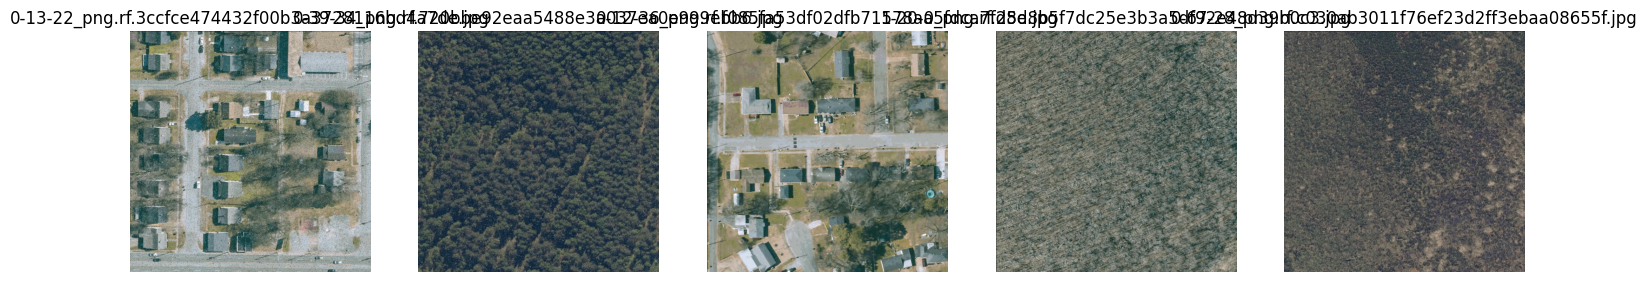

In [ ]:
sample_imgs = random.sample(os.listdir(img_folder), 5)

plt.figure(figsize=(18, 6))
for i, img_file in enumerate(sample_imgs):
    img = cv2.imread(os.path.join(img_folder, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

Image Quality Enhancement

In [ ]:
def denoise(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

def sharpen(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def blur(img):
    return cv2.GaussianBlur(img, (7, 7), 0)


Unique img shape

In [ ]:
sizes = []
for file in os.listdir(img_folder):
    img = cv2.imread(os.path.join(img_folder, file))
    sizes.append(img.shape[:2])

sizes = np.array(sizes)
print("Unique Image Sizes:")
np.unique(sizes, axis=0)


Unique Image Sizes:


array([[1024, 1024]])

Class Names & Class Distribution

In [ ]:
with open(dataset.location + "/data.yaml") as f:
    data_yaml = yaml.safe_load(f)

classes = data_yaml["names"]
print("Classes:", classes)


Classes: ['vegetation']


Class Count Plot

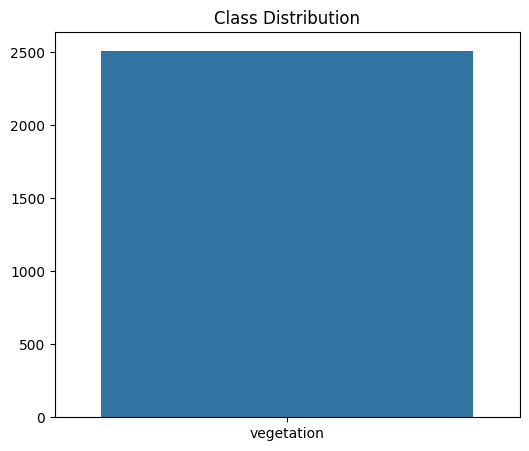

In [ ]:
label_files = glob.glob(lbl_folder + "/*.txt")

class_counts = {cls: 0 for cls in classes}

for lf in label_files:
    with open(lf) as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[classes[class_id]] += 1

plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.show()


Bounding Box Count Analysis

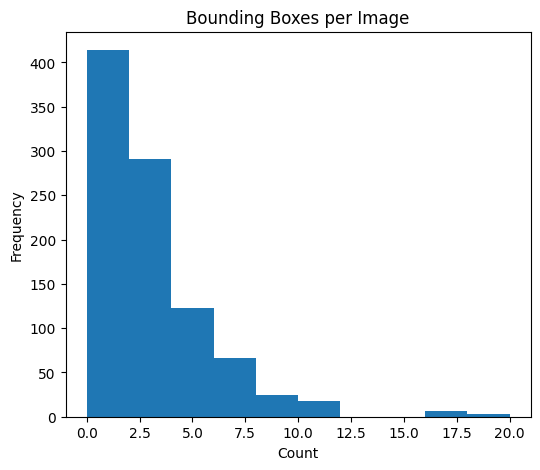

In [ ]:
bbox_count = []

for lf in label_files:
    with open(lf) as f:
        bbox_count.append(len(f.readlines()))

plt.figure(figsize=(6, 5))
plt.hist(bbox_count, bins=10)
plt.title("Bounding Boxes per Image")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()


Define ALL preprocessing functions

In [ ]:
def hist_equalize(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

def random_brightness(img):
    value = random.randint(-40, 40)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = np.clip(hsv[:,:,2] + value, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def sharpen(img):
    k = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    return cv2.filter2D(img, -1, k)

def flip(img):
    return cv2.flip(img, 1)

def rotate(img):
    ang = random.randint(-10, 10)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), ang, 1)
    return cv2.warpAffine(img, M, (w, h))

def final_resize(img):
    return cv2.resize(img, (640, 640))

def final_norm(img):
    return (img / 255.0).astype("float32")


Apply preprocessing to every image

In [ ]:
valid_ext = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

count = 0

for file in os.listdir(img_folder):
    if file.endswith(valid_ext):

        try:
            img_path = os.path.join(img_folder, file)
            img = cv2.imread(img_path)

            # Skip unreadable files
            if img is None:
                print("Skipping corrupt file:", file)
                continue

            # COLOR STEPS
            img = hist_equalize(img)
            img = random_brightness(img)
            img = sharpen(img)

            # AUGMENTATION
            if random.random() > 0.5:
                img = flip(img)
            img = rotate(img)

            # FINAL FIX
            img = final_resize(img)
            img = final_norm(img)

            # SAVE
            final_img = (img * 255).astype("uint8")
            cv2.imwrite(os.path.join(output_folder, file), final_img)

            count += 1

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

print("Preprocessing Completed!")
print("Total processed images:", count)


Error processing 0-25-47_png.rf.fe3c3128af573cea5a8379b325aa194c.jpg: Python integer -34 out of bounds for uint8
Error processing 0-22-49_png.rf.30e57f12673509eecf46987758f4060f.jpg: Python integer -26 out of bounds for uint8
Error processing 1-20-18_png.rf.0215907f0f4d479f35acdce02bd0fa31.jpg: Python integer -34 out of bounds for uint8
Error processing 0-35-28_png.rf.8884babd6e1fed9d8abd8b540ebf4d39.jpg: Python integer -36 out of bounds for uint8
Error processing 0-65-59_png.rf.cf9632f558b6ef2996cba7d95a19fca7.jpg: Python integer -4 out of bounds for uint8
Error processing 0-35-4_png.rf.8b820f416b6a5ee37d018f9720221ff9.jpg: Python integer -19 out of bounds for uint8
Error processing 0-27-38_png.rf.80d5d8c5b901e8453c04319c2455e1c8.jpg: Python integer -5 out of bounds for uint8
Error processing 0-1-19_png.rf.4f998264178587902c3a10da8116cdd2.jpg: Python integer -4 out of bounds for uint8
Error processing 0-27-38_png.rf.d79643a3c32ff0bfdd11dc49a15cb5b0.jpg: Python integer -36 out of bound